In [1]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Multi_Task_Full_Rank_Model, 
    train_multi_task, 
    model_eval
)

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [4]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="choice",
    data_type="all_ks",
    n_t_bins = 30
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
prior for this session is not found.
found 265 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 1525.45it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 230 (active: 230)
prior for this session is not found.
found 230 trials from 40.81 to 2252.10 sec.
found 74 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 230/230 [00:00<00:00, 5331.37it/s]


In [7]:
# an example of model training and eval

start_time = time.time()

example_pid = pids[0]

d = 0 # half window size
n_epochs = 7000

# prepare data
n_units = []
train_X_lst, train_Y_lst, test_X_lst, test_Y_lst = [], [], [], []
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=seed)
    train_X_lst.append(train_X)
    train_Y_lst.append(train_Y)
    test_X_lst.append(test_X)
    test_Y_lst.append(test_Y)
    n_units.append(C)

    
multi_task_frm = Multi_Task_Full_Rank_Model(
    n_tasks=len(pids),
    n_units=n_units, 
    n_t_bins=T, 
    half_window_size=d,
    soft_loss_penalty=1e-1
)

# training
multi_task_frm, train_losses = train_multi_task(
    model=multi_task_frm,
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=0,
    n_epochs=n_epochs,
)

# eval
test_Beta, test_metrics = model_eval(
    multi_task_frm, 
    train_dataset=(train_X_lst, train_Y_lst),
    test_dataset=(test_X_lst, test_Y_lst),
    behavior="choice"
)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

Epoch [700/7000], Loss: 12.295720951443158
Epoch [1400/7000], Loss: 9.915175686616129
Epoch [2100/7000], Loss: 8.92993332205922
Epoch [2800/7000], Loss: 5.704132421646486
Epoch [3500/7000], Loss: 2.8481759398950603
Epoch [4200/7000], Loss: 1.5923995435887828
Epoch [4900/7000], Loss: 0.38230939103328987
Epoch [5600/7000], Loss: 0.11523005608235086
Epoch [6300/7000], Loss: 0.03788242638006102
Epoch [7000/7000], Loss: 0.030856491290376886
task 0 train accuracy: 1.000 auc: 1.000
task 0 test accuracy: 0.811 auc: 0.880
task 1 train accuracy: 1.000 auc: 1.000
task 1 test accuracy: 0.913 auc: 0.985
time spent:  55.746 seconds


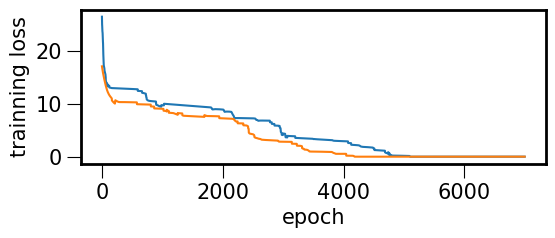

In [8]:
plt.figure(figsize=(6,2))
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("trainning loss")
plt.show()

In [9]:
R = 2 # rank
d = 0 # half window size
n_epochs = 7000
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

n_units = []
train_X_dict, test_X_dict, train_Y_dict, test_Y_dict = {}, {}, {}, {}
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    n_units.append(C)
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X_dict.update({pid: [X[train] for train, _ in skf.split(X, Y)]})
    test_X_dict.update({pid: [X[test] for _, test in skf.split(X, Y)]})
    train_Y_dict.update({pid: [Y[train] for train, _ in skf.split(X, Y)]})
    test_Y_dict.update({pid: [Y[test] for _, test in skf.split(X, Y)]})

In [10]:
# example of performing 5-fold CV on all sessions

start_time = time.time()

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

Beta_per_fold, metrics_per_fold = [], []
for fold_idx in range(n_folds):
    
    print(f"start training fold {fold_idx+1} on {len(pids)} sessions ..")
    train_X_lst = [train_X_dict[pid][fold_idx] for pid in pids]
    test_X_lst = [test_X_dict[pid][fold_idx] for pid in pids]
    train_Y_lst = [train_Y_dict[pid][fold_idx] for pid in pids]
    test_Y_lst = [test_Y_dict[pid][fold_idx] for pid in pids]
    
    multi_task_frm = Multi_Task_Full_Rank_Model(
        n_tasks=len(pids),
        n_units=n_units, 
        n_t_bins=T, 
        half_window_size=d,
        soft_loss_penalty=1e-1
    )

    # training
    multi_task_frm, train_losses = train_multi_task(
        model=multi_task_frm,
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        loss_function=torch.nn.BCELoss(),
        learning_rate=1e-3,
        weight_decay=0,
        n_epochs=n_epochs,
    )

    # eva
    test_Beta, test_metrics = model_eval(
        multi_task_frm, 
        train_dataset=(train_X_lst, train_Y_lst),
        test_dataset=(test_X_lst, test_Y_lst),
        behavior="choice"
    )
    Beta_per_fold.append(test_Beta)
    metrics_per_fold.append(test_metrics)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

start training fold 1 on 2 sessions ..
Epoch [700/7000], Loss: 13.180345332433106
Epoch [1400/7000], Loss: 11.139337053721853
Epoch [2100/7000], Loss: 9.588828788859033
Epoch [2800/7000], Loss: 7.1847823131040895
Epoch [3500/7000], Loss: 2.969923733414396
Epoch [4200/7000], Loss: 1.9074512649358548
Epoch [4900/7000], Loss: 0.7900025809476215
Epoch [5600/7000], Loss: 0.08764114903067681
Epoch [6300/7000], Loss: 0.035867872806669976
Epoch [7000/7000], Loss: 0.03214231562017288
task 0 train accuracy: 1.000 auc: 1.000
task 0 test accuracy: 0.943 auc: 0.990
task 1 train accuracy: 1.000 auc: 1.000
task 1 test accuracy: 0.870 auc: 0.944
start training fold 2 on 2 sessions ..
Epoch [700/7000], Loss: 13.278721746045484
Epoch [1400/7000], Loss: 11.556994090218208
Epoch [2100/7000], Loss: 10.239123054302247
Epoch [2800/7000], Loss: 7.7242962507548105
Epoch [3500/7000], Loss: 4.655965805680494
Epoch [4200/7000], Loss: 2.5039153322802
Epoch [4900/7000], Loss: 0.5904298804720792
Epoch [5600/7000], L

In [11]:
Betas, metrics_dict = {}, {}
for pid_idx, pid in enumerate(pids):
    metrics_dict.update({pid: np.mean(metrics_per_fold, 0)[pid_idx]})
    Betas.update({pid: [Beta_per_fold[fold_idx][pid_idx] for fold_idx in range(n_folds)]})

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ["accuracy", "auc"]
metrics_df

,accuracy,auc
dab512bd-a02d-4c1f-8dbc-9155a163efc0,0.901887,0.948828
febb430e-2d50-4f83-87a0-b5ffbb9a4943,0.882609,0.952304


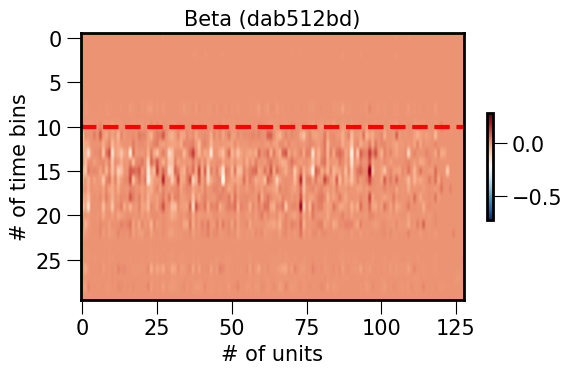

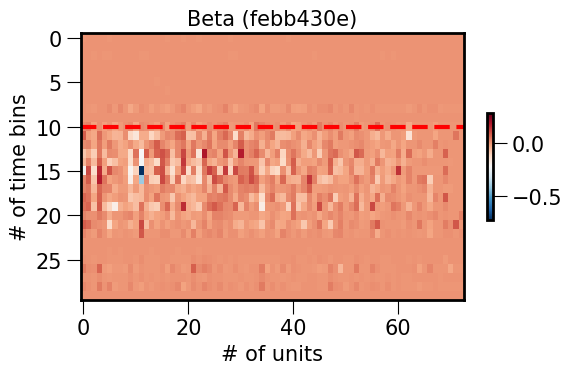

In [12]:
Betas_plot = []
for pid in pids:
    # average Beta across trials
    Betas_plot.append(np.array(Betas[pid]).mean(0).squeeze())
beta_min, beta_max = np.min(np.concatenate(Betas_plot)), np.max(np.concatenate(Betas_plot))
    
for pid_idx, pid in enumerate(pids):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    heatmap = ax.imshow(Betas_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=beta_min, vmax=beta_max)
    ax.axhline(y=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap, ax=ax, shrink=0.4)
    ax.set_ylabel("# of time bins")
    ax.set_xlabel("# of units")
    ax.set_title(f"Beta ({pid[:8]})")
    plt.tight_layout()